In [45]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
print(f"Using pmdarima {pm.__version__}")

Using pmdarima 1.8.2


In [2]:
df = pd.read_csv('../data/H1.csv')

In [3]:
df.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,...,No Deposit,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,0,13,2015,July,27,1,0,1,1,0,...,No Deposit,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,0,14,2015,July,27,1,0,2,2,0,...,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
df['YearWeek'] = df['ArrivalDateYear'].map(str) + '-' + df['ArrivalDateWeekNumber'].map(str)

In [5]:
df.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,YearWeek
0,0,342,2015,July,27,1,0,0,2,0,...,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-27
1,0,737,2015,July,27,1,0,0,2,0,...,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-27
2,0,7,2015,July,27,1,0,1,1,0,...,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-27
3,0,13,2015,July,27,1,0,1,1,0,...,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-27
4,0,14,2015,July,27,1,0,2,2,0,...,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-27


<AxesSubplot:xlabel='YearWeek'>

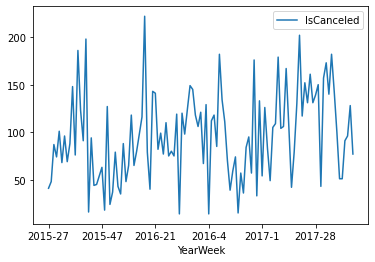

In [6]:
df.groupby(['YearWeek']).agg({'IsCanceled':'sum'}).plot()

In [7]:
canceled_ts = df.groupby(['YearWeek']).agg({'IsCanceled':'sum'}).reset_index()
canceled_ts.head()

,YearWeek,IsCanceled
0,2015-27,41
1,2015-28,48
2,2015-29,87
3,2015-30,74
4,2015-31,101


In [8]:
canceled_ts.describe()

,IsCanceled
count,115.000000
mean,96.713043
std,45.865510
min,14.000000
25%,64.000000
50%,95.000000
75%,127.500000
max,222.000000


In [9]:
# Adding Year Week Monday date as datetime index to pandas
# dt_format = '%Y-%W%w'
# canceled_ts['YearWeekMonday'] = pd.to_datetime(canceled_ts.index + '1', format='%Y-%W%w')
# canceled_ts['YearWeek'] = canceled_ts.index
# canceled_ts = canceled_ts.set_index(pd.DatetimeIndex(canceled_ts['YearWeekMonday']))

In [10]:
canceled_ts.head()

,YearWeek,IsCanceled
0,2015-27,41
1,2015-28,48
2,2015-29,87
3,2015-30,74
4,2015-31,101


<AxesSubplot:>

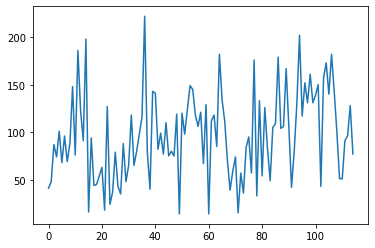

In [11]:
canceled_ts['IsCanceled'].plot()

In [12]:
canceled_ts.index

RangeIndex(start=0, stop=115, step=1)

In [13]:
(canceled_ts['IsCanceled']).name

'IsCanceled'

# Decompose time series into trend, seasonal and residuals

In [16]:
decompose_result = seasonal_decompose(canceled_ts['IsCanceled'], period=52)

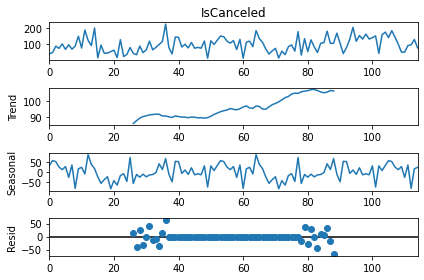

In [17]:
decompose_result.plot()
plt.show()

In [66]:
?plot_acf

# ACF and PACF

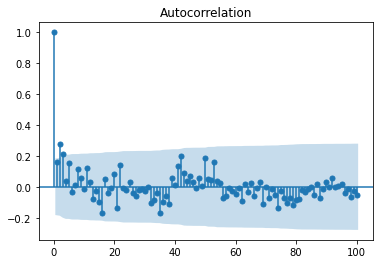

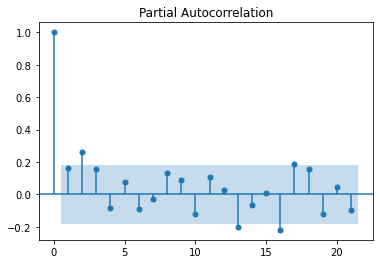

In [70]:
plot_acf(canceled_ts['IsCanceled'], lags=100)
plot_pacf(canceled_ts['IsCanceled'])

plt.show()

# SMA Window size 4

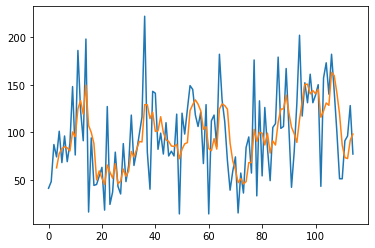

In [20]:
canceled_ts['IsCanceled'].plot()
canceled_ts['IsCanceled'].rolling(window=4).mean().plot()
plt.show()

# Split Time series 90/10

In [21]:
def ts_split(ts_series, test_size =0.10):
    'return train, test'
    test_len = int(test_size * len(canceled_ts['IsCanceled']))
    return ts_series[:-test_len], ts_series[-test_len:]

In [23]:
train_ts, test_ts = ts_split(canceled_ts['IsCanceled'])

In [24]:
len(train_ts), len(test_ts), len(canceled_ts['IsCanceled'])

(104, 11, 115)

# Auto Arima

In [26]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

In [27]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(train_ts, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train_ts, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 1


In [71]:
?pm.auto_arima

In [36]:
#auto arima
auto = pm.auto_arima(train_ts, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True, information_criterion='bic')

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=1103.803, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=1149.021, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=1107.214, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=1092.142, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=1144.421, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=1095.605, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : BIC=1096.173, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : BIC=1100.003, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : BIC=1088.097, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : BIC=1091.222, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : BIC=1091.844, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : BIC=1102.632, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : BIC=1095.665, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.753 seconds


In [37]:
print (auto.order)

(0, 1, 1)


In [38]:
model = auto

# Multi-Step Forecast

In [39]:
fc, conf_int = model.predict(n_periods=len(test_ts), return_conf_int=True)

In [40]:
fc

array([125.958652, 125.958652, 125.958652, 125.958652, 125.958652,
       125.958652, 125.958652, 125.958652, 125.958652, 125.958652,
       125.958652])

In [41]:
conf_int

array([[ 37.29000797, 214.62729604],
       [ 36.2495656 , 215.6677384 ],
       [ 35.22105268, 216.69625132],
       [ 34.20406804, 217.71323596],
       [ 33.1982325 , 218.7190715 ],
       [ 32.20318724, 219.71411677],
       [ 31.21859226, 220.69871175],
       [ 30.24412506, 221.67317895],
       [ 29.2794794 , 222.63782461],
       [ 28.32436415, 223.59293985],
       [ 27.37850232, 224.53880168]])

In [48]:
print(f"Root Mean squared error: {np.sqrt(mean_squared_error(test_ts, fc))}")
print(f"Ave test set: {np.mean(test_ts)}")
print(f"SMAPE: {smape(test_ts, fc)}")

Root Mean squared error: 44.99826625237395
Ave test set: 112.0
Ave train set: 95.09615384615384
SMAPE: 35.689477371663926


# One-step out Forecast

In [64]:
model.predict?

In [54]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test_ts:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Root Mean squared error: {np.sqrt(mean_squared_error(test_ts, forecasts))}")
print(f"Ave test set: {np.mean(test_ts)}")
print(f"SMAPE: {smape(test_ts, forecasts)}")

Root Mean squared error: 45.24842791095522
Ave test set: 112.0
SMAPE: 35.796591106229144


In [58]:
test_ts

104    173
105    140
106    182
107    143
108    100
109     51
110     51
111     91
112     96
113    128
114     77
Name: IsCanceled, dtype: int64

In [59]:
forecasts

[101.19091719468929,
 112.22168258683527,
 115.96681061563086,
 125.68386544681363,
 128.94600026568833,
 123.87881527646249,
 114.15326909285096,
 106.00147733054473,
 103.60942078943236,
 102.37696240407504,
 106.26084239511597]

In [65]:
confidence_intervals

[[12.966949870768019, 189.41488451861056],
 [23.629810032397188, 200.81355514127335],
 [27.477766136084114, 204.4558550951776],
 [36.789713300278606, 214.57801759334865],
 [40.33326171639696, 217.55873881497968],
 [35.44857686214675, 212.30905369077823],
 [25.320532032650036, 202.9860061530519],
 [16.80791399686578, 195.19504066422368],
 [14.701564525428367, 192.51727705343637],
 [13.788616243319794, 190.9653085648303],
 [17.897506277939854, 194.62417851229208]]

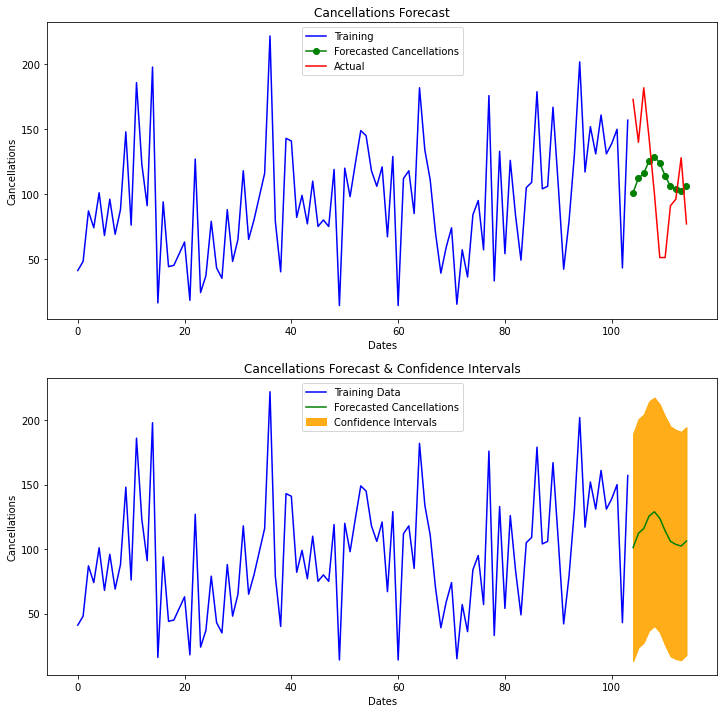

In [63]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(train_ts, color='blue', label='Training')
axes[0].plot(test_ts.index, forecasts, color='green', marker='o',
             label='Forecasted Cancellations')

axes[0].plot(test_ts.index, test_ts, color='red', label='Actual')
axes[0].set_title('Cancellations Forecast')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Cancellations')

#axes[0].set_xticks(np.arange(0, 114, 1).tolist(), canceled_ts['YearWeek'][0:120:1].tolist())
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(train_ts, color='blue', label='Training Data')
axes[1].plot(test_ts.index, forecasts, color='green',
             label='Forecasted Cancellations')

axes[1].set_title('Cancellations Forecast & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Cancellations')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_ts.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

#axes[1].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
axes[1].legend()

In [74]:
#auto arima with 52 week Seasonal differencing and extending p, q, P, Q with more time for 30 fits
auto = pm.auto_arima(train_ts, start_p=0, start_q=0, max_p=10, max_q=10,
                     start_P=0, start_Q=0, max_P=10, max_Q=10, m=52,
                     d=1, D=1, seasonal=True, stepwise=True,
                     suppress_warnings=True, error_action="ignore",
                     trace=True, information_criterion='bic', nfits=30, random_state=1)

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,1,0)[52]             : BIC=611.668, Time=0.28 sec
 ARIMA(1,1,0)(1,1,0)[52]             : BIC=inf, Time=3.24 sec
 ARIMA(0,1,1)(0,1,1)[52]             : BIC=inf, Time=4.34 sec
 ARIMA(0,1,0)(1,1,0)[52]             : BIC=inf, Time=5.73 sec
 ARIMA(0,1,0)(0,1,1)[52]             : BIC=inf, Time=5.62 sec
 ARIMA(0,1,0)(1,1,1)[52]             : BIC=619.082, Time=10.97 sec
 ARIMA(1,1,0)(0,1,0)[52]             : BIC=594.248, Time=0.35 sec
 ARIMA(1,1,0)(0,1,1)[52]             : BIC=inf, Time=7.57 sec
 ARIMA(1,1,0)(1,1,1)[52]             : BIC=602.012, Time=4.72 sec
 ARIMA(2,1,0)(0,1,0)[52]             : BIC=585.310, Time=0.77 sec
 ARIMA(2,1,0)(1,1,0)[52]             : BIC=inf, Time=10.90 sec
 ARIMA(2,1,0)(0,1,1)[52]             : BIC=inf, Time=9.05 sec
 ARIMA(2,1,0)(1,1,1)[52]             : BIC=592.461, Time=13.84 sec
 ARIMA(3,1,0)(0,1,0)[52]             : BIC=585.410, Time=0.87 sec
 ARIMA(2,1,1)(0,1,0)[52]             : BIC=582.567, Time=1

In [75]:
print(auto.order)
model = auto

(0, 1, 2)


In [76]:
fc, conf_int = model.predict(n_periods=len(test_ts), return_conf_int=True)

In [77]:
print(f"Root Mean squared error: {np.sqrt(mean_squared_error(test_ts, fc))}")
print(f"Ave test set: {np.mean(test_ts)}")
print(f"SMAPE: {smape(test_ts, fc)}")

Root Mean squared error: 52.06870707819739
Ave test set: 112.0
SMAPE: 39.89665504455417


In [79]:
auto = pm.auto_arima(train_ts,
                      start_p=0,
                      start_q=0,
                      max_p=10,
                      max_q=10,
                      start_P=0,
                      start_Q=0,
                      max_P=10,
                      max_Q=10,
                      m=52,
                      stepwise=True,
                      seasonal=True,
                      information_criterion='bic',
                      trace=True,
                      d=1,
                      D=1,
                      error_action='warn',
                      suppress_warnings=True,
                      random_state = 0,
                      n_fits=30)

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,1,0)[52]             : BIC=611.668, Time=0.30 sec
 ARIMA(1,1,0)(1,1,0)[52]             : BIC=inf, Time=3.38 sec
 ARIMA(0,1,1)(0,1,1)[52]             : BIC=inf, Time=4.22 sec
 ARIMA(0,1,0)(1,1,0)[52]             : BIC=inf, Time=5.28 sec
 ARIMA(0,1,0)(0,1,1)[52]             : BIC=inf, Time=5.59 sec
 ARIMA(0,1,0)(1,1,1)[52]             : BIC=619.082, Time=10.53 sec
 ARIMA(1,1,0)(0,1,0)[52]             : BIC=594.248, Time=0.36 sec
 ARIMA(1,1,0)(0,1,1)[52]             : BIC=inf, Time=7.85 sec
 ARIMA(1,1,0)(1,1,1)[52]             : BIC=602.012, Time=4.54 sec
 ARIMA(2,1,0)(0,1,0)[52]             : BIC=585.310, Time=0.74 sec
 ARIMA(2,1,0)(1,1,0)[52]             : BIC=inf, Time=11.36 sec
 ARIMA(2,1,0)(0,1,1)[52]             : BIC=inf, Time=9.27 sec
 ARIMA(2,1,0)(1,1,1)[52]             : BIC=592.461, Time=14.12 sec
 ARIMA(3,1,0)(0,1,0)[52]             : BIC=585.410, Time=0.86 sec
 ARIMA(2,1,1)(0,1,0)[52]             : BIC=582.567, Time=1

In [83]:
print(auto.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  104
Model:             SARIMAX(0, 1, 2)x(0, 1, [], 52)   Log Likelihood                -283.749
Date:                             Thu, 28 Oct 2021   AIC                            573.497
Time:                                     01:05:13   BIC                            579.293
Sample:                                          0   HQIC                           575.712
                                             - 104                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.1019      0.162     -6.783      0.000      -1.420      -0.784
ma.L2          0.3546      

In [84]:
print(auto.order)
model = auto
fc, conf_int = model.predict(n_periods=len(test_ts), return_conf_int=True)

(0, 1, 2)


In [85]:
print(f"Root Mean squared error: {np.sqrt(mean_squared_error(test_ts, fc))}")
print(f"Ave test set: {np.mean(test_ts)}")
print(f"SMAPE: {smape(test_ts, fc)}")

Root Mean squared error: 52.06870707819739
Ave test set: 112.0
SMAPE: 39.89665504455417


In [86]:
fc, conf_int

(array([165.6353104 , 182.26530047, 178.26530047, 151.26530047,
        139.26530047, 154.26530047, 100.26530047, 162.26530047,
         47.26530047, 145.26530047, 151.26530047]),
 array([[  43.56202509,  287.70859571],
        [  59.55964565,  304.97095529],
        [  51.74324794,  304.787353  ],
        [  21.03864488,  281.49195606],
        [   5.43655215,  273.09404879],
        [  16.92890351,  291.60169743],
        [ -40.49136182,  241.02196276],
        [  18.16953359,  306.36106734],
        [-100.09392755,  194.62452849],
        [  -5.28666442,  295.81726536],
        [  -2.41308508,  304.94368602]]))

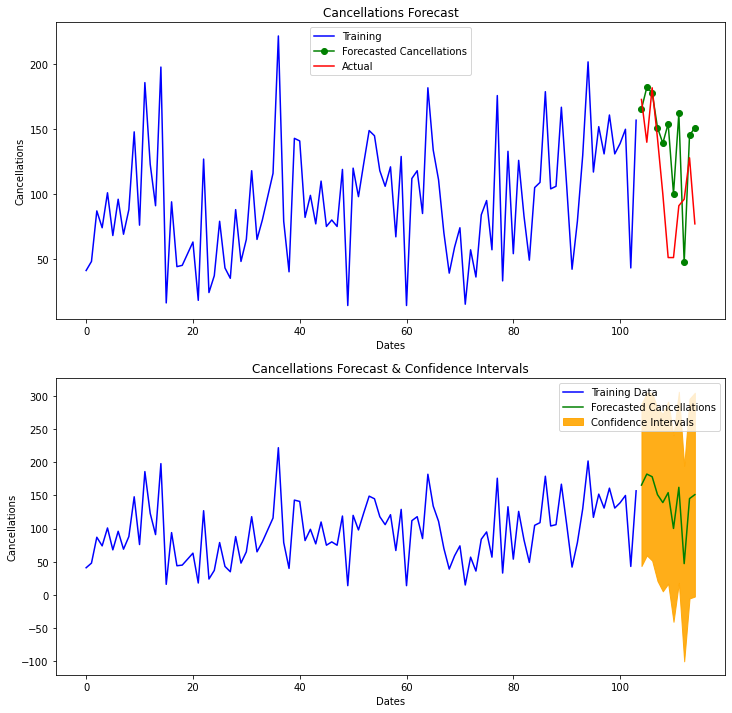

In [87]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(train_ts, color='blue', label='Training')
axes[0].plot(test_ts.index, fc, color='green', marker='o',
             label='Forecasted Cancellations')

axes[0].plot(test_ts.index, test_ts, color='red', label='Actual')
axes[0].set_title('Cancellations Forecast')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Cancellations')

#axes[0].set_xticks(np.arange(0, 114, 1).tolist(), canceled_ts['YearWeek'][0:120:1].tolist())
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(train_ts, color='blue', label='Training Data')
axes[1].plot(test_ts.index, fc, color='green',
             label='Forecasted Cancellations')

axes[1].set_title('Cancellations Forecast & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Cancellations')

conf_int = np.asarray(conf_int)
axes[1].fill_between(test_ts.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

#axes[1].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
axes[1].legend()

In [88]:
from pydlm import dlm, trend, seasonality

In [89]:
df2 = pd.read_csv('../data/h2weekly.csv')

In [90]:
df2.head()

,Date,IsCanceled
0,2015-06-21,97
1,2015-06-28,153
2,2015-07-05,228
3,2015-07-12,321
4,2015-07-19,159


<AxesSubplot:>

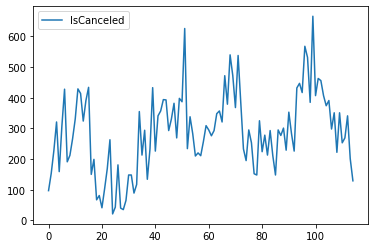

In [91]:
df2.plot()

# A Simple Dynamic Linear Model

In [94]:
from pydlm import dlm, trend, dynamic
# Linear trend
linear_trend = trend(degree=1, discount=0.98, name='linear_trend', w=10.0)
# Seasonality
seasonal52 = seasonality(period=52, discount=0.99, name='seasonal52', w=10.0)
# Simple DLM
simple_dlm = dlm(df2['IsCanceled'])+linear_trend + seasonal52


Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...


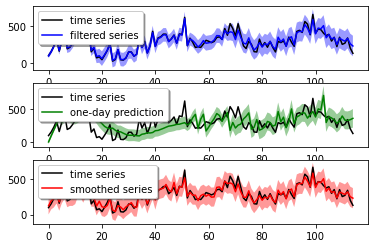

In [115]:
# Fit the model
simple_dlm.fit()
# Plot the fitted results
simple_dlm.turnOff('data points')
simple_dlm.plot()

In [98]:
simple_dlm.getMSE()


18247.66405340592

In [99]:
np.sqrt(simple_dlm.getMSE())

135.0839148581574

/Users/Santhosh/Projects/Python/env/lib/python3.7/site-packages/pydlm/plot/dlmPlot.py:519: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(str(size[0]) + str(size[1]) + str(location))


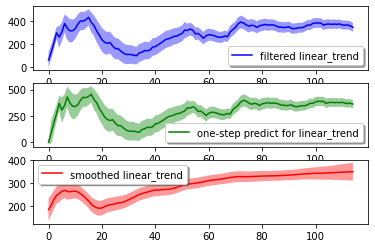

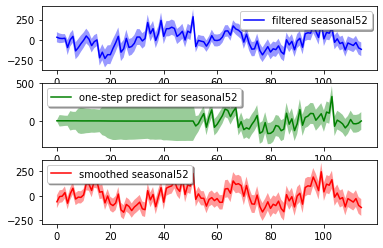

In [106]:
# Plot each component (attribute the time series to each component)
simple_dlm.turnOn('predict plot')
simple_dlm.turnOn('filtered plot')
simple_dlm.plot('linear_trend')
simple_dlm.plot('seasonal52')

In [173]:
train_ts, test_ts = ts_split(df2['IsCanceled'], test_size =.10)

In [174]:
train_ts.shape, test_ts.shape

((104,), (11,))

In [175]:
# Simple DLM
simple_dlm = dlm(train_ts)+linear_trend + seasonal52
# Fit the model
simple_dlm.fit()


Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


/Users/Santhosh/Projects/Python/env/lib/python3.7/site-packages/pydlm/plot/dlmPlot.py:519: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(str(size[0]) + str(size[1]) + str(location))


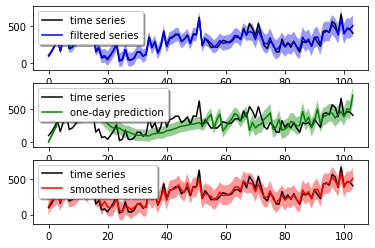

In [176]:
# Plot the fitted results
simple_dlm.turnOff('data points')
simple_dlm.plot()

In [177]:
simple_dlm.getMSE()

19084.89783268981

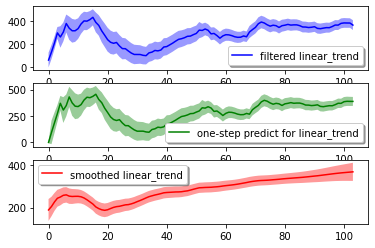

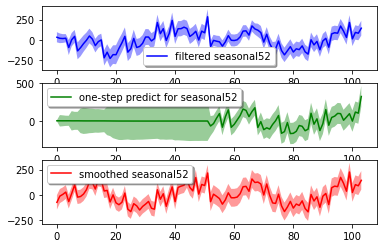

In [178]:
# Plot each component (attribute the time series to each component)
simple_dlm.turnOn('predict plot')
simple_dlm.turnOn('filtered plot')
simple_dlm.plot('linear_trend')
simple_dlm.plot('seasonal52')

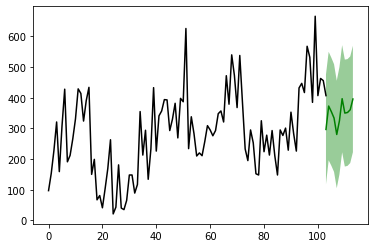

In [179]:
# Plot the prediction give the first 104 weeks and forcast the next 11 weeks.
simple_dlm.plotPredictN(N=11)


<AxesSubplot:>

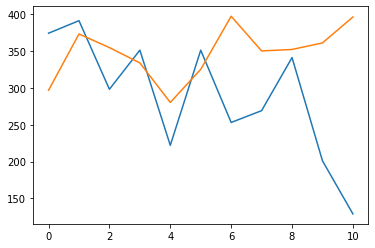

In [190]:
test_ts.reset_index(drop=True).plot()
pd.Series(fc).plot()

In [182]:
fc = simple_dlm.predictN(N=11)[0]

In [183]:
print(f"Root Mean squared error: {np.sqrt(mean_squared_error(test_ts, fc))}")
print(f"Ave test set: {np.mean(test_ts)}")
print(f"SMAPE: {smape(test_ts, fc)}")

Root Mean squared error: 112.05790082288856
Ave test set: 289.09090909090907
SMAPE: 28.479339373872357
